In [1]:
import torch
import torchvision
from torchvision import datasets as dset
from torchvision import transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import json
from random import shuffle
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from torchtext.data import get_tokenizer
import numpy as np
import math
import time
import sys
import re
import pandas as pd
import h5py
from tqdm import tqdm

In [2]:
# set seed
torch.manual_seed(1234)

In [3]:
class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="START",
        end_word="END",
        unk_word="UNK",         
        annotations_file="captions_val2014.json",
        pad_word="PAD",
        vocab_from_file=False):
        """
        Initialize the vocabulary.
        Args:
        -----
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          pad_word: Pad token.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.pad_word = pad_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        # create / load the vocab
        self.get_vocab()

    def get_vocab(self):
        """
        Load the vocabulary from file OR build the vocabulary from scratch.
        """
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """
        Populate the dictionaries for converting tokens to integers (and vice-versa).
        """
        self.init_vocab()
        # add special tokens andd all tokens from all captions
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_word(self.pad_word)
        self.add_captions()

    def init_vocab(self):
        """
        Initialize the dictionaries for converting tokens to integers (and vice-versa).
        """
        self.word2idx = {} 
        self.idx2word = {} 
        self.idx = 0

    def add_word(self, word):
        """
        Add a token to the vocabulary.
        Args:
        ----
            word: str
                Token to be added.
        """
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """
        Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold.
        """
#         coco = COCO(self.annotations_file)
        with open("../../../data/3dshapes_captions.json", "r") as fp:
                self.labels = json.load(fp)
            
        
        ids = [i for lst in self.labels.keys() for i in self.labels[lst]]
        
        counter = Counter()
#         ids = coco.anns.keys()
        for i, id in enumerate(ids):
#             caption = str(coco.anns[id]['caption'])
            caption = str(id)
            caption = caption.lower().strip()
            caption = re.sub(r"[^a-zA-Z.,!?]+", r" ", caption)
            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(caption) 
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        """
        Return index of given word.
        Args:
        ----
            word: str
        Returns:
            int: index of word
        """
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        """
        Returns number of unique tokens in vocabulary. 
        """
        return len(self.word2idx)

In [4]:
class COCOCaptionsDataset(Dataset):
    """
    Custom class for preprocessing datapoints and sampling a random caption per image.
    For training, 70.000 images are sampled.
    
    Args:
    ----
        file: str
            Path to annotations json file.
        download_dir: str
            Path to root directory containing images and annotations.
        img_transform: transformations.Compose
            Transformations to be applied to the loaded image before it is embedded.
        batch_size: int
            Batch size.
        mode: str
            Train, test or validation.
        vocab_threshold: int
            Minimal token frequency to be considered in the vocab.
        vocb_file: str
            Path to vocab file.
        start_toke, end_token, unk_token, pad_token: str
            Special tokens.
        vocab_from_file: bool
            Load existing vocab from file?
        max_sequence_length: int
            Max length to which captions will be truncated.
        
    """
    def __init__(self, file, download_dir, img_transform, batch_size, mode, 
                 vocab_threshold, vocab_file, start_token, end_token, unk_token, pad_token, 
                vocab_from_file, max_sequence_length=0):
        """
        Initialize a dataset instance loading image-caption pairs from the MS COCO Captions dataset.
        """
        self.transform = img_transform
        self.mode = mode
        self.batch_size = batch_size
        # instantiating the vocab object 
        self.vocab = Vocabulary(vocab_threshold, vocab_file, 
                                start_token, end_token, unk_token, file, pad_token, vocab_from_file) 
        self.max_sequence_length = max_sequence_length
        self.pad_token = pad_token
        
        # some distinctions below for Train and test mode (root dir and whether there are captions)
        if mode == "train":
            self.image_dir = os.path.join(download_dir, "train2014")
            self.coco = COCO(file) 
#             _ids = list(self.coco.anns.keys())
#             shuffle(_ids)
            # take 70.000 images from the dataset
            self.ids = torch.load("val_split_IDs_from_COCO_train.pt")[:1000] # #_ids[:70000] # ("../pretrain_img_IDs_2imgs_512dim.pt")# torch.load("../pretrain_img_IDs_2imgs_512dim.pt").tolist() #
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english") 
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))]
            self.caption_lengths = [len(token) for token in all_tokens]
            # get maximum caption length for padding
            self.max_caption_length = max(self.caption_lengths)
            
            # print pretraining IDs for later separation from functional training
#             with open("pretrain_img_IDs.txt", 'w') as f:
#                 f.write(",".join([str(i) for i in self.ids]))
                
        elif mode == "val":
            self.image_dir = os.path.join(download_dir, "val2014")
            self.coco = COCO(file) 
            self.ids = torch.load("../pretrain_img_IDs_2imgs_512dim.pt").tolist() #list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english")
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))] # tqdm(np.arange(len(self.ids)))
            self.caption_lengths = [len(token) for token in all_tokens]
            
        else:
            self.image_dir = os.path.join(download_dir, "val2014")
            # no annotations here 
            test_info = json.loads(open(file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
    
    def __len__(self):
        """
        Return number of available data points.
        """
        if self.mode != "test":
            return len(self.ids)
        else:
            return len(self.paths)
    
    def __getitem__(self, idx):
        """
        Return an image-caption tuple. A random caption per images is chosen since the dataset maps captions onto images.
        
        Arguments:
        -------
        idx: int
            Index of the item to be returned.
        Returns:
        -----
        image: torch.tensor((3,224,224))
        caption: torch.tensor((len_caption))
        """
        
        # obtain image and caption if in training mode
        if self.mode != 'test':
            # get target and distractor indices
            target_idx = idx[0]
            distractor_idx = idx[1]
            
            ann_id = self.ids[target_idx]
            target_caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            target_path = self.coco.loadImgs(img_id)[0]['file_name']

            # get distarctor
            dist_id = self.ids[distractor_idx]
            dist_img_id = self.coco.anns[dist_id]['image_id']
            distractor_path = self.coco.loadImgs(dist_img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            target_image = Image.open(os.path.join(self.image_dir, target_path)).convert('RGB')
            target_image = self.transform(target_image)

            distractor_image = Image.open(os.path.join(self.image_dir, distractor_path)).convert('RGB')
            distractor_image = self.transform(distractor_image)

            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(str(target_caption).lower())
            # Convert caption to tensor of word ids, append start and end tokens.
            target_caption = []
            target_caption.append(self.vocab(self.vocab.start_word))

            # check if the sequence needs to be padded or truncated
            if self.max_sequence_length != 0:
                tokens = tokens[:self.max_sequence_length]

            target_caption.extend([self.vocab(token) for token in tokens])
            target_caption.append(self.vocab(self.vocab.end_word))
            target_caption = torch.Tensor(target_caption).long()
            return target_image, distractor_image, target_caption

        # obtain image if in test mode
        else:
            path = self.paths[idx[0]]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            # return original image and pre-processed image tensor
            return orig_image, image
        
#     def get_train_indices(self):
#         """
#         Return a list of indices at which the captions have the same length which was sampled at random 
#         for the given batch. To be used for pretraining the speaker (base image-captioning model).
        
#         Returns:
#         -----
#             indices: list
#                 List of indices of caption-image pairs to be used in the batch.
#         """
#         sel_length = np.random.choice(self.caption_lengths)
#         all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
#         indices = list(np.random.choice(all_indices, size=self.batch_size))
        
#         return indices
    
    def get_func_train_indices(self):
        """
        Simple POC function returning two lists on indices for the functional training. 
        Returns a list of inidces for targets and a list f indices for distractors. 
        Captions are of same lengths for targets and distractors (will be optimized).
        
        Returns:
        -------
            list: (int, int)
                List of tuples of target and distractor indices, each for a single reference game iteration.
        """
        
        sel_length_t = np.random.choice(self.caption_lengths)

        all_indices_t = np.where([self.caption_lengths[i] == sel_length_t for i in np.arange(len(self.caption_lengths))])[0]

        indices_t = list(np.random.choice(all_indices_t, size=self.batch_size))
        possible_inds_dist = [x for x in np.arange(len(self.caption_lengths)) if x not in indices_t]
        indices_d = list(np.random.choice(possible_inds_dist, size=self.batch_size))
        
        return list(zip(indices_t, indices_d))

In [6]:
class threeDshapes_Dataset(Dataset):
    """
    Dataset class for loading the dataset of images and captions from the 3dshapes dataset.
    """
    def __init__(
        self,
        file, 
        download_dir, 
        img_transform, 
        text_transform, 
        batch_size, 
        mode, 
        vocab_threshold, 
        vocab_file, 
        start_token, 
        end_token,
        unk_token,
        pad_token, 
        vocab_from_file, 
        embedded_imgs,
        vocab_from_pretrained=False,
        max_sequence_length=0,
        categorize_imgs=False,
        ):

        self.transform = img_transform
        self.mode = mode # train or test or val
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, 
                                start_token, end_token, unk_token, 
                                file, pad_token, vocab_from_file) 
        self.max_sequence_length = max_sequence_length
        self.pad_token=pad_token
        self.embedded_imgs=embedded_imgs
        self.tokenizer = get_tokenizer("basic_english")

        if mode == "train":
            self.image_dir = os.path.join(download_dir, "3dshapes_np.npy") # download_dir needs to be data/train/ then 
            self.images = np.load(self.image_dir) # ["images"] # os.path.join(download_dir, file)
            with open("../../../data/3dshapes_captions_fixed.json", "r") as fp:
                self.labels = json.load(fp)
            with open("../../../data/3dshapes_captions_short.json", "r") as fp:
                self.labels_short = json.load(fp)
            
            imgIDs4train = torch.load("../val_img_IDs_wShort_unique_3dshapes.pt")#np.random.choice(list(self.labels.keys()), 30000) # train split # np.random.choice(torch.load("../val_img_IDs_unique_3dshapes.pt"), 200) 
            _ids = [(self.labels[i], i) for i in imgIDs4train]
            #             _ids = [(self.labels[i], i) for i in imgIDs4train] # list of tuples of shape (annID_lst, imgID)
#             _anns_flat = [i for lst in _ids for i in np.random.choice(lst[0], 5)] # only select 5 random captions among 40 possible 
#             self._img_ids_flat = torch.load( "../pretrain_img_IDs_flat_3dshapes_short.pt")#[i[1] for i in _ids for x in i[0][:5]]
#             _unique_IDs = list(set(self._img_ids_flat))
#             _anns_flat = []
#             for i in _unique_IDs:
#                 short_caps = np.random.choice(self.labels_short[i], 3)
#                 long_caps = np.random.choice(self.labels[i], 2)
#                 _anns_flat.extend(short_caps)
#                 _anns_flat.extend(long_caps)
                
            
#             self.ids = torch.load("../pretrain_anns_flat_3dshapes_short.pt")#_anns_flat
            self._img_ids_flat = [i[1] for i in _ids for x in i[0][:6]]
            # _unique_IDs = list(set(self._img_ids_flat))
            _anns_flat = []
            for i in imgIDs4train:
                short_caps = np.random.choice(self.labels_short[i], 3)
                long_caps = np.random.choice(self.labels[i], 3)
                _anns_flat.extend(short_caps)
                _anns_flat.extend(long_caps)
            self.ids = _anns_flat
            
            print("IDS ", len(self.ids), self.ids[:10])
            print("img IDs ", len(self._img_ids_flat), self._img_ids_flat[:10])

            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english") # nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower())
            all_tokens = [tokenizer(str(self.ids[index]).replace("-", "")) for index in tqdm(np.arange(len(self.ids)))] 
            self.caption_lengths = [len(token) for token in all_tokens]
            
            # print pretraining IDs for later separation from functional training
            # save used indices to torch file
            print("Type check before saving: ", type(imgIDs4train[0]))
#             torch.save(imgIDs4train, "pretrain_img_IDs_unique_3dshapes.pt")
#             torch.save(self._img_ids_flat, "pretrain_img_IDs_flat_3dshapes.pt")
#             torch.save(self.ids, "pretrain_anns_flat_3dshapes.pt")
            
        if mode == "val":
            pass

    def __len__(self):
        return len(self.ids)
        # for extracting resnet features:
#         return len(self.images)

    def __getitem__(self, idx):
        if self.mode != "test":
            target_idx = idx[0]
            distractor_idx = idx[1]
            # just accessing images directly for resnet feature extraction
            target_img = self.images[int(self._img_ids_flat[target_idx])]
            target_lbl = self.ids[target_idx]
            
            dist_img = self.images[int(self._img_ids_flat[distractor_idx])] # self.images[int(distractor_idx)] #
            dist_lbl = self.ids[distractor_idx]

            target_img = np.asarray(target_img).astype('uint8')

            dist_img = np.asarray(dist_img).astype('uint8')

            target_img = self.transform(target_img)
            dist_img = self.transform(dist_img)

            target_features = self.embedded_imgs[int(self._img_ids_flat[target_idx])]
            distractor_features = self.embedded_imgs[int(self._img_ids_flat[distractor_idx])]

            tokens = self.tokenizer(str(target_lbl).lower().replace("-", ""))
            tokens_dist = self.tokenizer(str(dist_lbl).lower().replace("-", ""))
            # Convert caption to tensor of word ids, append start and end tokens.
            target_caption = []
            distractor_caption = []
            target_caption.append(self.vocab(self.vocab.start_word))
            distractor_caption.append(self.vocab(self.vocab.start_word))

            # check if the sequence needs to be padded or truncated
            if self.max_sequence_length != 0:
                tokens = tokens[:self.max_sequence_length]
                tokens_dist = tokens_dist[:self.max_sequence_length]

            target_caption.extend([self.vocab(token) for token in tokens])
            target_caption.append(self.vocab(self.vocab.end_word))
            target_caption = torch.Tensor(target_caption).long()

            distractor_caption.extend([self.vocab(token) for token in tokens_dist])
            distractor_caption.append(self.vocab(self.vocab.end_word))
            distractor_caption = torch.Tensor(distractor_caption).long()

            return target_img, dist_img, target_features, distractor_features, target_caption

    def get_func_train_indices(self):
        """
        Simple POC function returning two lists on indices for the functional training. 
        Returns a list of inidces for targets and a list f indices for distractors. 
        Captions are of same lengths for targets and distractors (will be optimized).
        
        Returns:
        -------
            list: (int, int)
                List of tuples of target and distractor indices, each for a single reference game iteration.
        """
        
        sel_length_t = np.random.choice(self.caption_lengths)

        all_indices_t = np.where([self.caption_lengths[i] == sel_length_t for i in np.arange(len(self.caption_lengths))])[0]

        indices_t = list(np.random.choice(all_indices_t, size=self.batch_size))
        # retrieve image ids of sampled ids to make sure we don't get target distractor pairs
        # consisiting of same images
        imgIDs_t = [self._img_ids_flat[i] for i in indices_t]
        possible_inds_dist = [x for x in np.arange(len(self.caption_lengths)) if x not in indices_t and self._img_ids_flat[x] not in imgIDs_t]
        indices_d = list(np.random.choice(possible_inds_dist, size=self.batch_size))
        
        return list(zip(indices_t, indices_d))


In [5]:
# utility wrapper returning a DataLoader for training 
def get_loader(transform,
               mode='val',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/val/",
              ):
    """
    Returns the data loader.
    Args:
    ----
      transform: transforms.Compose
          Image transform.
      mode: str 
          One of 'train', 'val' or 'test'.
      batch_size: int
          Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: int
          Minimum word count threshold.
      vocab_file: str
          File containing the vocabulary. 
      start_word, end_word, unk_word, pad_word: str
          Special tokens.
      vocab_from_file: bool
          If False, create vocab from scratch & override any existing vocab_file.
          If True, load vocab from from existing vocab_file, if it exists.
      num_workers: int
          Number of subprocesses to use for data loading 
      
    Returns:
    ------
        data_loader: torch.DataLoader
    """
    
    assert mode in ['train', 'test', 'val'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train' or mode=='val', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'val':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "val2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json')
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "train2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_train2014.json')
    if mode == 'test':
        # TBD
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(download_dir, "val2014/") #'test2014/'
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json') 

    # build COCO caption dataset.
    dataset = COCOCaptionsDataset(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word, 
        vocab_from_file=vocab_from_file,
        max_sequence_length=25,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_func_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=torch.utils.data.sampler.BatchSampler(
                                          sampler=initial_sampler,
                                          batch_size=dataset.batch_size,
                                          drop_last=False),
                                                 )
    else:
        data_loader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=dataset.batch_size,
            shuffle=True)

    return data_loader

In [8]:
def get_loader_3dshapes(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='../../data/vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/",
               vocab_from_pretrained=False,
               categorize_imgs=False,
               embedded_imgs="COCO_train_ResNet_features_reshaped_dict.pt",
              ):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    img_folder = os.path.join(download_dir, "") #'test2014/'
    annotations_file = os.path.join(download_dir, '') #image_info_test2014

    # TODO: alternatively, modify / sort the image IDS on the instantiated dataset.ids object 
    # COCO caption dataset.
    dataset = threeDshapes_Dataset(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        text_transform=None,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word,
        vocab_from_file=vocab_from_file,
        vocab_from_pretrained=vocab_from_pretrained,
        max_sequence_length=25,
        categorize_imgs=categorize_imgs,
        embedded_imgs=embedded_imgs,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_func_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(
            dataset=dataset, 
            num_workers=num_workers,
            batch_sampler=torch.utils.data.sampler.BatchSampler(sampler=initial_sampler,
                                                                batch_size=dataset.batch_size,
                                                                drop_last=False))

    return data_loader

In [6]:
# speaker language module
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, visual_embed_size, batch_size=1, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the sentence beginning).
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            visual_embed_size: int
                Dimensionality of the image embedding to be appended at each time step as additional context.
            num_layers: int
                Number of LST layers.
        """
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.visual_embed_size = visual_embed_size
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        # LSTM takes as input the word embedding with prepended embeddings of the two images at each time step
        self.lstm = nn.LSTM(self.embed_size + 2*self.visual_embed_size, self.hidden_size , self.num_layers, batch_first=True) #self.embed_size+
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.project = nn.Linear(2048, self.visual_embed_size)
        self.batch_size = batch_size
        self.hidden = self.init_hidden(self.batch_size)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self, batch_size):
            
        """ 
        At the start of training, we need to initialize a hidden state;
        Defines a hidden state with all zeroes
        The axes are (num_layers, batch_size, hidden_dim)
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, features, captions, prev_hidden):
        """
        Perform forward step through the LSTM.
        
        Args:
        -----
            features: torch.tensor((batch_size, embedd_size))
                Embeddings of images.
            captions: torch.tensor((batch_size, caption_length))
                Lists of indices representing tokens of each caption.
        Returns:
        ------
            outputs: torch.tensor((batch_size, caption_length, embedding_dim))
                Scores over vocabulary for each token in each caption.
        """
        
        image_emb = self.project(features)
        # print("Target emb after unsqueeze: ", target_emb.shape)
        # concat
        img_features = torch.cat((image_emb[:, 0, :], image_emb[:, 1, :]), dim=-1).unsqueeze(1)
        # print("concat features: ", img_features.shape)
        embeddings = self.embed(captions)
        # features = features.unsqueeze(1)
        
        # print("repeated img features: ", features_reps.shape)
        # PREpend the feature embedding as additional context AT EACH TIMESTEP, cut off END token 
        if self.training:
            features_reps = img_features.repeat(1, captions.shape[1]-1, 1) # captions.shape[1]-1
            embeddings = torch.cat((features_reps, embeddings[:, :-1,:]), dim=-1) # features_reps, dim=-1 # :-1
#         print("embeddings: ", embeddings.shape)
        else:
        # PUT BACK THE SHIFT FOR VALIDATION -- REMOVE FOR SAMPLING
            features_reps = img_features.repeat(1, captions.shape[1]-1, 1) # captions.shape[1]-1
            
            embeddings = torch.cat((features_reps, embeddings[:, :-1,:]), dim=-1)
        hiddens, hidden_state = self.lstm(embeddings, prev_hidden)
        # print("Hidden_state within forward: ", hidden_state)
        
        outputs = self.linear(hiddens)
        return outputs, hidden_state
    
    def sample(self, inputs, max_sequence_length):
        """
        Function for sampling a caption during functional (reference game) training.
        Implements greedy sampling. Sampling stops when END token is sampled or when max_sequence_length is reached.
        Also returns the log probabilities of the action (the sampled caption) for REINFORCE.
        
        Args:
        ----
            inputs: torch.tensor(1, 1, embed_size)
                pre-processed image tensor.
            max_sequence_length: int
                Max length of sequence which the nodel should generate. 
        Returns:
        ------
            output: list
                predicted sentence (list of tensor ids). 
        """
        
        
        output = []
        raw_outputs = [] # for structural loss computation
        log_probs = []
        entropies = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
        softmax = nn.Softmax(dim=-1)
        # create initial caption input: "START"
        caption = torch.tensor([0, 0]).repeat(1, 1) # two 0s since we cut off last token in forward step, so that we actually keep one
        # make initial forward step, get output of shape (batch_size, 1, vocab_size)
        init_hiddens = self.init_hidden(batch_size)
        ####
        # outsource first step bc of image projection
        out, hidden_state = self.forward(inputs, caption, init_hiddens)
        raw_outputs.extend(out)
        probs = softmax(out)
        if self.training:
            cat_dist = torch.distributions.categorical.Categorical(probs)
            cat_samples = cat_dist.sample()
            entropy = cat_dist.entropy()
            entropies.append(entropy)
            log_p = cat_dist.log_prob(cat_samples)
        else:
            max_probs, cat_samples = torch.max(probs, dim = -1)
            log_p = torch.log(max_probs)
            entropy = -max_probs * log_p
            entropies.append(entropy)

        output.append(cat_samples)
        cat_samples = torch.cat((cat_samples, cat_samples), dim=-1)
        # print("Cat samples ", cat_samples)
        log_probs.append(log_p)
        # output.append(cat_samples)
        word_emb = self.embed(cat_samples)

        # while True:
        for i in range(max_sequence_length):
            out, hidden_state = self.forward(inputs, cat_samples, hidden_state)
            # lstm_out, hidden_state = self.lstm(word_emb, hidden_state)
            # print("Self hidden after an iter of sampling loop: ", hidden_state )
            # out = self.linear(lstm_out)
            
            # get and save probabilities and save raw outputs
            raw_outputs.extend(out)
            probs = softmax(out)
            ####
            if self.training:
                # try sampling from a categorical
                cat_dist = torch.distributions.categorical.Categorical(probs)
                cat_samples = cat_dist.sample()
                entropy = cat_dist.entropy()
                entropies.append(entropy)
                log_p = cat_dist.log_prob(cat_samples)
            else: 
                # if in eval mode, take argmax
                max_probs, cat_samples = torch.max(probs, dim = -1)
                log_p = torch.log(max_probs)
                
                top5_probs, top5_inds = torch.topk(probs, 5, dim=-1)
                
            output.append(cat_samples)
            cat_samples = torch.cat((cat_samples, cat_samples), dim=-1)
            # print("Cat samples ", cat_samples)
            log_probs.append(log_p)
            # embed predicted tokens
            word_emb = self.embed(cat_samples)
            
        output = torch.stack(output, dim=-1).squeeze(1)
        # stack
        log_probs = torch.stack(log_probs, dim=1).squeeze(-1)
        entropies = torch.stack(entropies, dim=1).squeeze(-1)
        
        ####
        # get effective log prob and entropy values - the ones up to (including) END (word2idx = 1)  
        # mask positions after END - both entropy and log P should be 0 at those positions
        end_mask = output.size(-1) - (torch.eq(output, 1).to(torch.int64).cumsum(dim=-1) > 0).sum(dim=-1)
        # include the END token
        end_inds = end_mask.add_(1).clamp_(max=output.size(-1)) # shape: (batch_size,)
        for pos, i in enumerate(end_inds):  
            # zero out log Ps and entropies
            log_probs[pos, i:] = 0
            entropies[pos, i:] = 0
        ####
    
        raw_outputs = torch.stack(raw_outputs, dim=1).view(batch_size, -1, self.vocabulary_size)
        return output, log_probs, raw_outputs, entropies

In [11]:
embedded_imgs = torch.load("../train_logs/COCO_train_ResNet_features_reshaped_dict.pt")
# embedded_imgs = torch.load("../train_logs/3dshapes_all_ResNet_features_reshaped_all_sq.pt")

In [7]:
transform_test = transforms.Compose([#transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])
data_loader_test = get_loader(transform=transform_test,
                         mode='train',
                         batch_size=1,
                         vocab_threshold=25,
                         vocab_from_file=True,
                         download_dir="../../../data/train", 
                              vocab_file="vocab4000.pkl"
                        )
# data_loader_test = get_loader_3dshapes(transform=transform_test,
#                          mode='train',
#                          batch_size=1,
#                          vocab_threshold=25,
#                          vocab_from_file=True,
#                          download_dir="../../../data", 
#                               vocab_file="vocab3dshapes_short.pkl",
#                                        embedded_imgs=embedded_imgs
#                         )

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
Obtaining caption lengths...


In [12]:
data_loader_test.dataset._img_ids_flat[1619597]
embedded_imgs[int('287396')].shape

AttributeError: 'COCOCaptionsDataset' object has no attribute '_img_ids_flat'

In [8]:
def clean_sentence(output):
    """
    Transform list of indices to a sentence.
    """
    list_string = []
    
    for idx in output:
#         print(idx)
        for i in idx:
#             print("i: ", i)
            try:
                list_string.append(data_loader_test.dataset.vocab.idx2word[i.item()])
            except ValueError:
                for y in i:
                    list_string.append(data_loader_test.dataset.vocab.idx2word[y.item()])
    list_string = list_string[:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

In [9]:
decoder_file = 'speaker_wTopkTrain_coco_vocab4000_0.75ls_topk_temperature_decoding_decoder-coco-512dim-topk_temp20-21.pkl'
# decoder_file = "speaker-decoder-vocab49-metrics-full-3dshapes_ls02_fixed-2.pkl"
embed_size = 512
visual_embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_test.dataset.vocab)
print("VOCAB: ", vocab_size)
# Initialize the encoder and decoder, and set each to inference mode.
# encoder = EncoderMLP(2*2048, 2*visual_embed_size)
# encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, visual_embed_size)
decoder.eval()

# Load the trained weights.
# encoder.load_state_dict(torch.load(os.path.join('./../models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./../models', decoder_file)))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# encoder.to(device)
decoder.to(device)

VOCAB:  4054


DecoderRNN(
  (embed): Embedding(4054, 512)
  (lstm): LSTM(1536, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=4054, bias=True)
  (project): Linear(in_features=2048, out_features=512, bias=True)
)

/Users/polinatsvilodub/.local/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


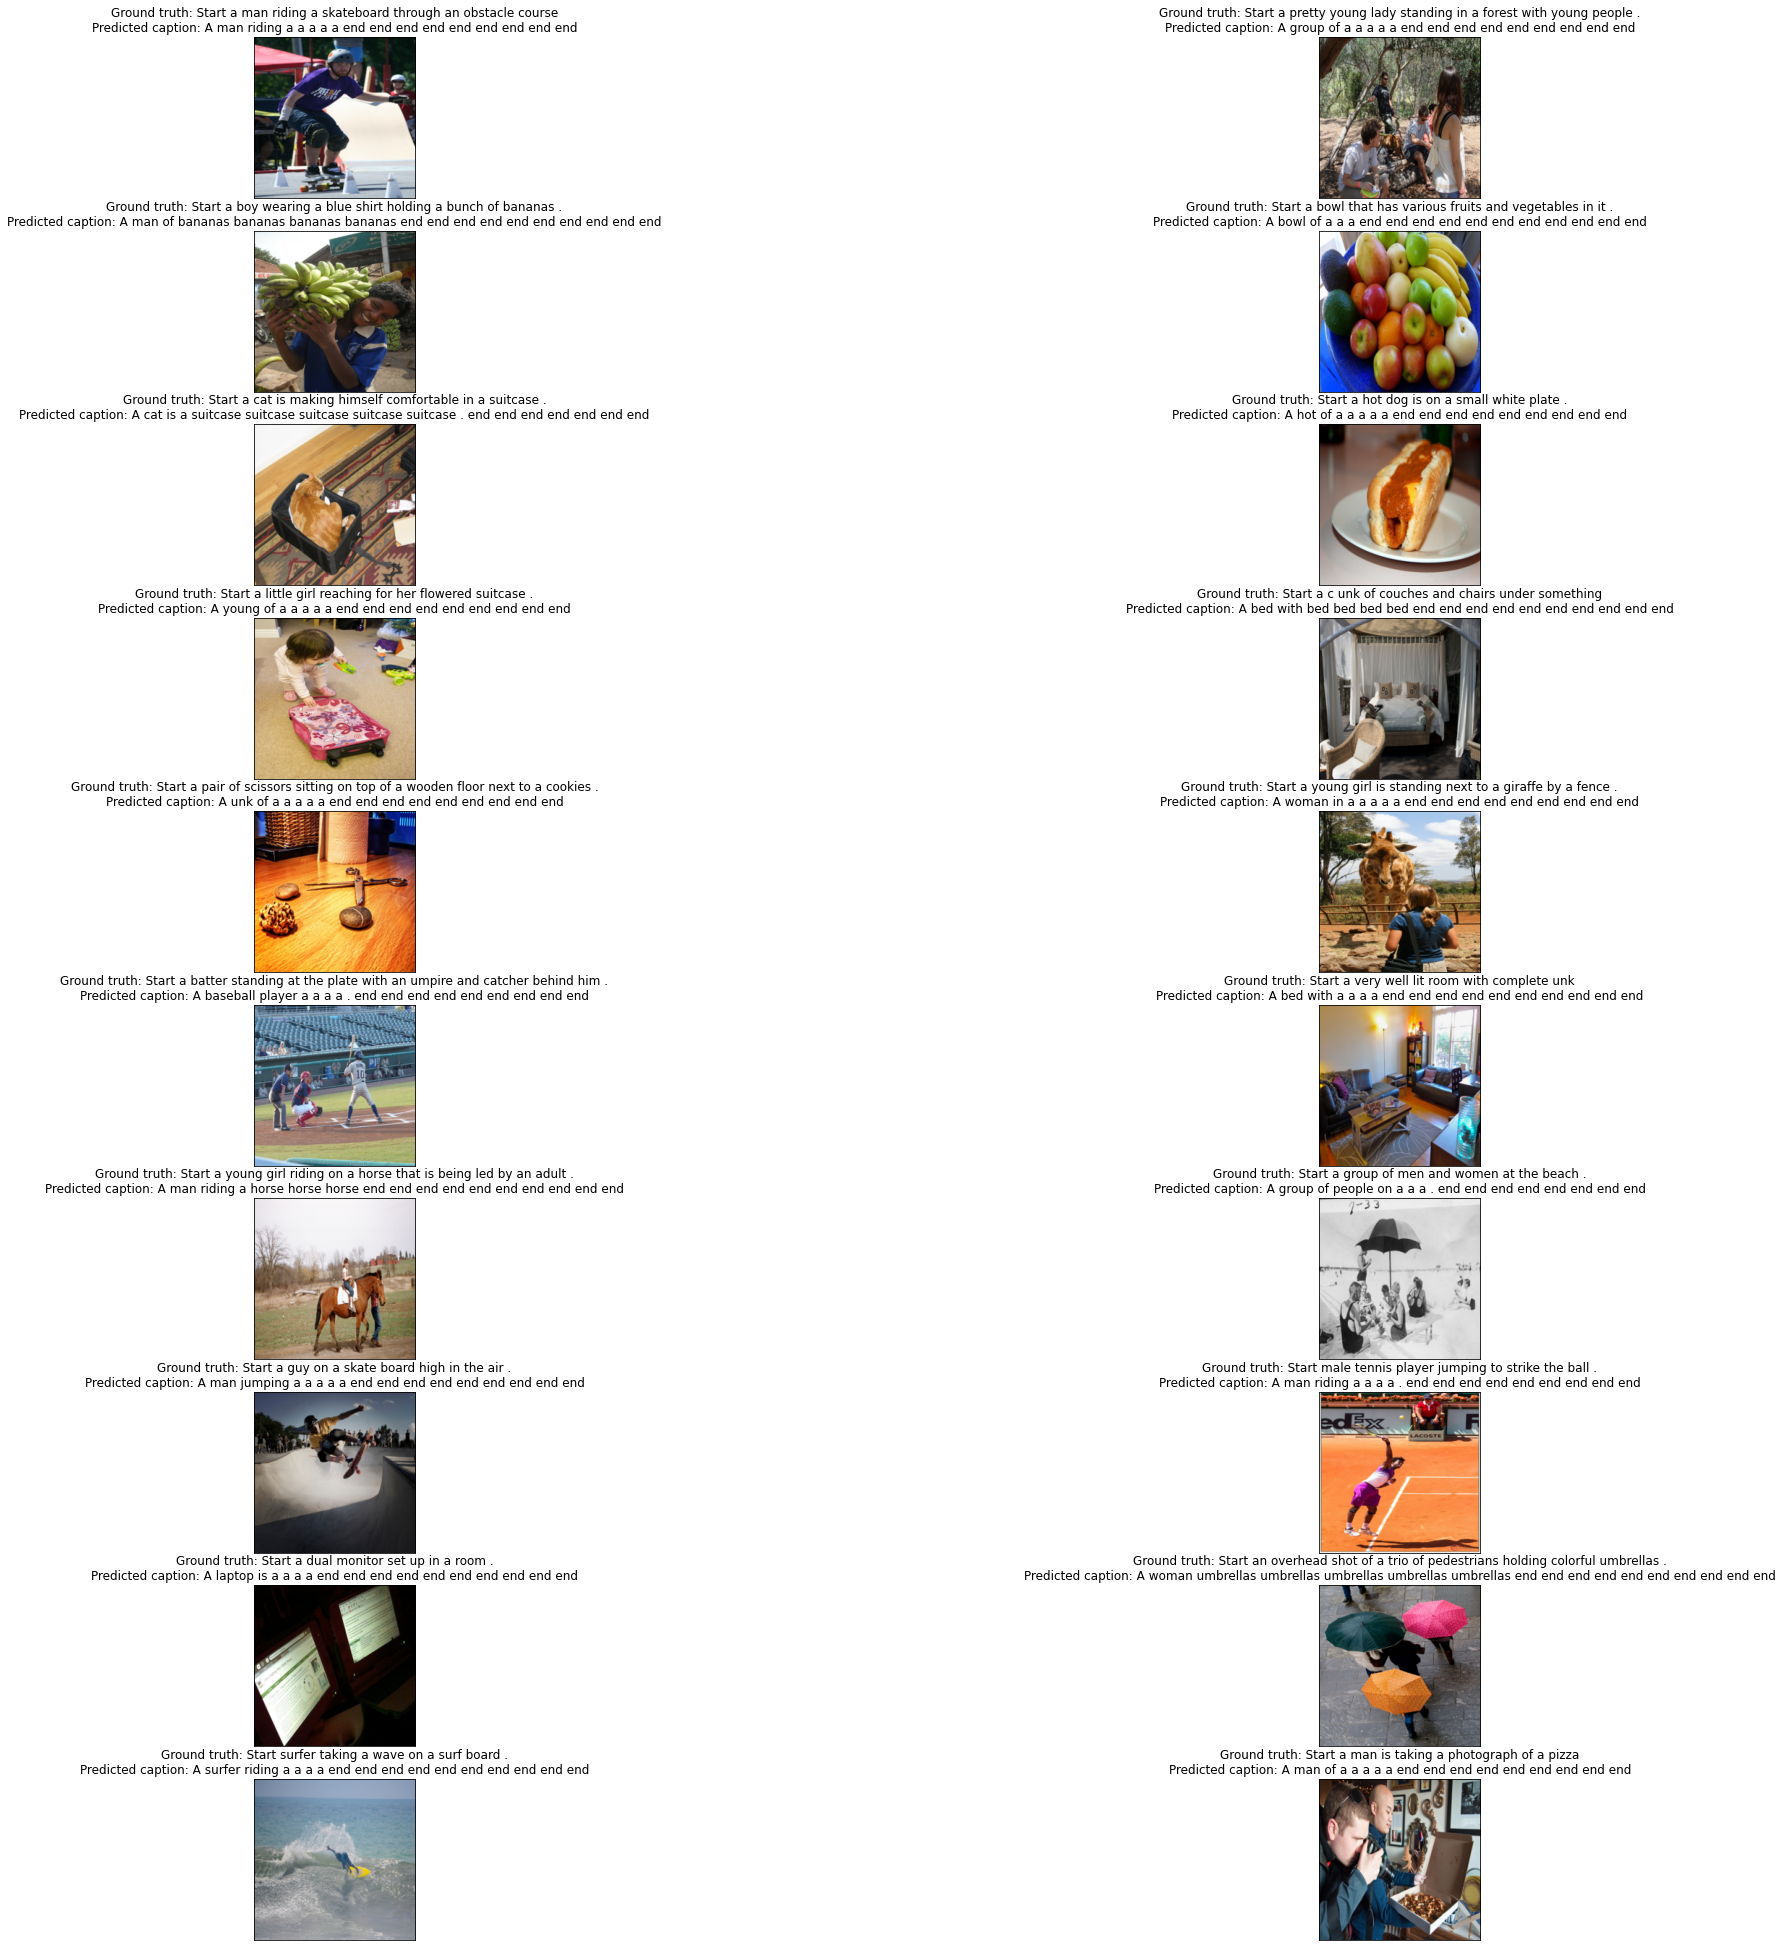

In [12]:
# iterate over 15 image pairs to manually inspect performance of the model
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(35, 35))

# helper for un-transforming the images for viz purposes
inv_transform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], 
                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                         std = [ 1., 1., 1. ]),
])

# collect some stats about the generated captions
ground_truth_num_tokens = 0
ground_truth_num_tokens_lst = []
predicted_num_tokens = 0
predicted_num_tokens_lst = []
sentences = []

# this same loop can be used for collecting results on ground truth vs generated caption lengths 
# it is especially interesting to see if the model is able to generate shorter captions 
# i.e. filter occurences of ground truth short captions and check average difference to predicted length
# just comment out plotting part

for i in range(10):
    test_indices = data_loader_test.dataset.get_func_train_indices() 
    test_targets = torch.tensor([x[0] for x in test_indices]).long()
    test_dists = torch.tensor([x[1] for x in test_indices]).long()
    
    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=test_indices)
    data_loader_test.batch_sampler.sampler = new_sampler        
    
    # get the images
    orig_image, dist_image, cap = next(iter(data_loader_test))    
#     orig_image, dist_image, saved_target_features, saved_dist_features, cap = next(iter(data_loader_test)) #
    ground_truth_num_tokens += cap.shape[1] - 2 # remove start and end token 
    ground_truth_num_tokens_lst.append(cap.shape[1]-2)
    
    
    # retrieve saved features 
    saved_target_features = embedded_imgs[str(data_loader_test.dataset.ids[test_targets.item()])]#torch.index_select(embedded_imgs, 0,  test_targets).squeeze(1)
    saved_dist_features = embedded_imgs[str(data_loader_test.dataset.ids[test_dists.item()])]#torch.index_select(embedded_imgs, 0,  test_dists).squeeze(1)
#     saved_target_features = embedded_imgs[int(data_loader_test.dataset._img_ids_flat[test_targets.item()])]
#     saved_dist_features = embedded_imgs[int(data_loader_test.dataset._img_ids_flat[test_dists.item()])]
    
    # both_images = [saved_target_features, saved_dist_features] #torch.cat((saved_target_features, saved_dist_features), dim=-1)
    both_images = torch.cat((saved_target_features.unsqueeze(0).unsqueeze(0), saved_dist_features.unsqueeze(0).unsqueeze(0)), dim=1)
    
#     both_images = torch.cat((saved_target_features.unsqueeze(0), saved_dist_features.unsqueeze(0)), dim=1)
    
    
    output, log_p, raw, topk = decoder.sample(both_images, 17) # features_emb.unsqueeze(1)
    # out, hidden_state = decoder(both_images, cap, decoder.init_hidden(1))
    # print("Output", out)
    sentence_t = clean_sentence(output)
#     print('example sentence for target:\n', sentence_t)
    if "end" in sentence_t:
        len_sentence_t = sum([1 for x in sentence_t.split(" ")[:sentence_t.split(" ").index("end")] if x != "end" ])
    else:
        len_sentence_t = len(sentence_t.split(" "))
        
    predicted_num_tokens += len_sentence_t
    predicted_num_tokens_lst.append(len_sentence_t)
    sentences.append(" ".join(sentence_t.split()[:len_sentence_t]))
    both_images_d = torch.cat((saved_dist_features.unsqueeze(0).unsqueeze(1), saved_target_features.unsqueeze(0).unsqueeze(1)), dim=1) #[saved_dist_features, saved_target_features] #torch.cat((saved_dist_features, saved_target_features), dim=-1)
#     both_images_d = torch.cat((saved_dist_features.unsqueeze(0), saved_target_features.unsqueeze(0)), dim=1) #[saved_dist_features, saved_target_features] #torch.cat((saved_dist_features, saved_target_features), dim=-1)
    
    output2, log_p2, raw2, topk2 = decoder.sample(both_images_d, 17) #both_features_d.unsqueeze(1)
    sentence_d = clean_sentence(output2)
#     print('example sentence for distractor:\n', sentence_d)
    
#     permute the images to get the ground truth caption of the distractor
    test_indices_d = [(test_indices[0][1], test_indices[0][0])]
    
    new_sampler_d = torch.utils.data.sampler.SubsetRandomSampler(indices=test_indices_d)
    data_loader_test.batch_sampler.sampler = new_sampler_d        
    _, _, cap_dist = next(iter(data_loader_test))
#     _, _, _, _, cap_dist = next(iter(data_loader_test))
#     show the image, ground truth caption and predicted caption
    axs[i, 0].imshow(inv_transform(orig_image)[0].squeeze(0).permute(1,2,0))
    axs[i, 0].set_title("Ground truth: " + clean_sentence(cap) + "\nPredicted caption: " + sentence_t)
    axs[i, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    # distractor 
    axs[i, 1].imshow(inv_transform(dist_image)[0].squeeze(0).permute(1,2,0))
    axs[i, 1].set_title("Ground truth: " + clean_sentence(cap_dist) + "\nPredicted caption: " + sentence_d)
    axs[i, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

fig.show()

In [47]:
# TODO compute some test accuracy
sentences

['A bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom',
 'A water water water water water water water water water water water water water water water water',
 'A bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom',
 'A bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom',
 'A bathroom bathroom bathroom sized bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom',
 'A bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom',
 'A bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom bathroom cups bathroom bathroom bathroom',
 'A w

## Plotting stats, metrics etc

In [13]:
# train_losses = pd.read_csv('../functional_training_losses_wPretrained_noEnc_vocab4000_metrics_full_epoch_2.csv'): default train params results
# train_metrics = pd.read_csv("../functional_training_wPretrained_language_drift_metrics_train_full_epoch_2.csv")
# train_metrics = pd.read_csv("../functional_training_wPretrained_3dshapes_wShort_language_drift_metrics_train_full_epoch_3.csv") # mixed length default train params results
# train_losses = pd.read_csv("../functional_training_losses_wPretrained_3dshapes_wShort_metrics_full_epoch_3.csv")
# train_losses = pd.read_csv("../functional_training_losses_wPretrained_coco_lr05-1000_ls05_epoch_2.csv")
# train_losses = pd.read_csv("../functional_training_losses_wPretrained_coco_lr05-1000_ls05_fixed_epoch_1.csv")
# train_metrics = pd.read_csv("../functional_training_metrics_wPretrained_coco_lr05-1000_ls05_epoch_2.csv")
train_losses = pd.read_csv("../reference_game_losses_coco_075ls_topk_wTopkTrain_decoder-coco-512dim-topk_temp20-2epoch_1.csv")
train_metrics = pd.read_csv("../functional_training_COCO_language_drift_metrics_lf01_epoch_2.csv")

In [14]:
train_losses.head()

,steps,speaker_s,speaker_f,speaker_loss,listener,perplexities,accuracies,image_similarities,mean_mean_baselines
0,1,3.805659,7.995477,4.853113,0.708563,44.954845,0.593750,0.549841,0.00000
1,2,4.397708,-20.249306,-1.764045,0.733063,81.264389,0.531250,0.573235,0.12500
2,3,3.895500,-16.199556,-1.128264,0.806803,49.180656,0.515625,0.567188,0.09375
3,4,3.967067,-0.675082,2.806530,0.656029,52.829330,0.609375,0.559075,0.12500
4,5,3.948806,-5.075397,1.692755,0.685827,51.873398,0.593750,0.588072,0.13750


In [17]:
train_metrics.head()

,steps,structural_drift_pred,structural_drift_true,semantic_drifts_true,semantic_drifts_pred,discrete_overlaps,continuous_overlaps,image_similarities,epochs_out
0,500,-93.064758,-91.858589,-10.732233,-16.227201,0,-0.046755,0.593332,1
1,500,-99.078293,-77.665649,-9.052645,-9.408304,-1,-0.075862,0.534610,1
2,500,-98.751404,-68.315865,-12.472035,-15.473924,0,-0.057042,0.576751,1
3,500,-88.874924,-96.505959,-11.177734,-16.951477,0,-0.102788,0.506405,1
4,500,-107.125282,-83.683456,-8.847508,-13.061581,1,-0.152009,0.496691,1


In [60]:
train_metrics["semantic_drifts_true"].iloc[0]

'(-2.7816672325134277, tensor([[[2.4741e-08, 1.9520e-05, 1.3159e-06, 1.9042e-08, 2.9325e-01,\n          4.3597e-07, 1.2961e-05, 3.0852e-06, 1.0970e-04, 3.0024e-01,\n          6.8793e-07, 5.7137e-10, 2.0933e-05, 8.8626e-07, 1.1768e-06,\n          1.4521e-04, 2.6274e-07, 2.4840e-06, 2.4861e-06, 7.0873e-07,\n          1.4235e-05, 3.3416e-05, 8.5471e-09, 1.6961e-09, 9.7943e-06,\n          5.0502e-08, 2.2787e-05, 3.6464e-08, 1.5418e-04, 3.4682e-05,\n          1.7381e-05, 8.4260e-08, 8.0146e-05, 1.6333e-08, 2.5126e-05,\n          5.5527e-05, 1.9523e-05, 7.1343e-06, 5.6491e-06, 3.9027e-06,\n          1.6645e-05, 1.7165e-06, 1.3711e-06, 5.6025e-07, 9.7309e-05,\n          1.7293e-05, 2.2933e-05, 4.0555e-01, 4.8486e-06],\n         [1.2742e-09, 8.7491e-06, 2.5970e-04, 1.4162e-09, 1.6794e-06,\n          3.9973e-06, 1.5429e-04, 2.9267e-04, 4.6560e-06, 3.4948e-05,\n          6.5072e-08, 1.2097e-10, 2.4170e-07, 5.4808e-10, 2.6477e-08,\n          3.7062e-06, 1.9612e-11, 8.8484e-05, 1.2528e-09, 4.3169e

In [15]:
# train_losses["speaker"] = train_losses["speaker_s"] + train_losses["speaker_f"]
train_losses["plot_steps"] = list(range(0, len(train_losses["listener"])))

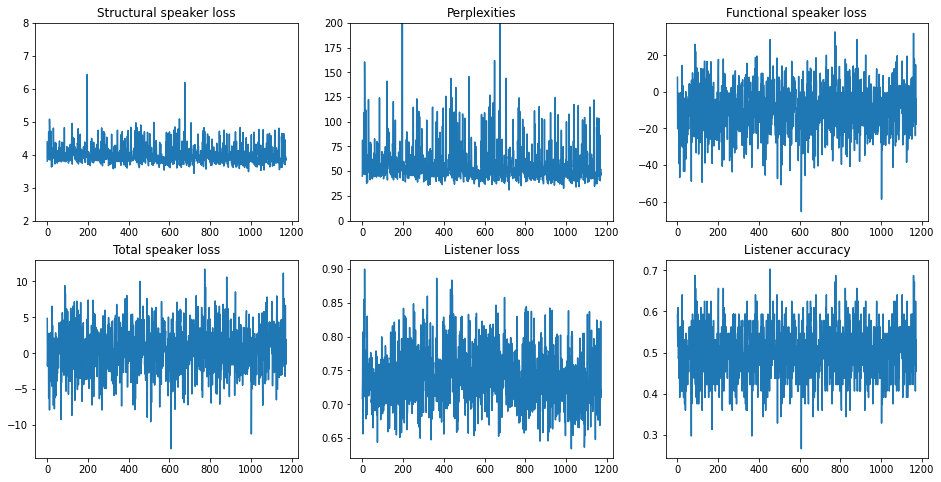

In [16]:
fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 3

fig.add_subplot(2,3, 1)
plt.plot(train_losses["plot_steps"], train_losses['speaker_s'], label="S_s")
plt.ylim(ymin=2, ymax=8)
plt.title("Structural speaker loss")
fig.add_subplot(2,3, 2)
plt.plot(train_losses["plot_steps"], train_losses['perplexities'], label="PPL")
plt.ylim(ymin=0, ymax=200)
plt.title("Perplexities")
fig.add_subplot(2,3,3)
plt.plot(train_losses["plot_steps"], train_losses['speaker_f'], label="S_f")
plt.title("Functional speaker loss")

fig.add_subplot(2,3, 4)
plt.plot(train_losses["plot_steps"], train_losses['speaker_loss'], label="Speaker loss")
plt.title("Total speaker loss")
fig.add_subplot(2,3,5)
plt.plot(train_losses["plot_steps"], train_losses['listener'], label="Listener loss")
plt.title("Listener loss")
fig.add_subplot(2,3,6)
plt.plot(train_losses["plot_steps"], train_losses['accuracies'], label="Acc")
plt.title("Listener accuracy")

plt.show()


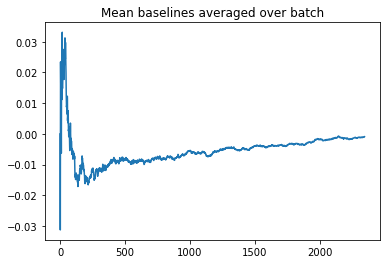

In [49]:
plt.plot(train_losses["plot_steps"], train_losses['mean_mean_baselines'], label="MB")
plt.title("Mean baselines averaged over batch")

plt.show()


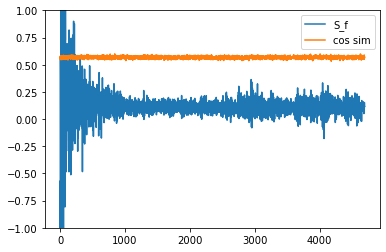

In [8]:
plt.plot(train_losses["plot_steps"], train_losses['speaker_f'], label="S_f")
plt.plot(train_losses["plot_steps"], train_losses['image_similarities'], label="cos sim")
plt.ylim(ymin=-1, ymax=1)
plt.legend()
plt.show()

In [9]:
len(train_metrics)/64
train_metrics['epoch'] = [1]*64*4 + [2]*64*4 #+ [3]*64*5

In [11]:
train_metrics_summary = train_metrics.groupby(["steps", "epoch"]).mean() 
train_metrics_summary["steps_ungrouped"] = [500, 500, 1000, 1000, 1500, 1500, 2000, 2000] # , 2500, 2500, 2500
train_metrics_summary["epoch_ungrouped"] = [1, 2, 1, 2, 1, 2, 1, 2] # , 1, 2, 3
train_metrics_summary["plot_step"] = train_metrics_summary["steps_ungrouped"] * train_metrics_summary["epoch_ungrouped"] + (train_metrics_summary["epoch_ungrouped"]-1 )* 2500 #[500, 2500, 1000, 3000, 1500, 3500, 2000, 4000]#train_metrics_summary["steps_ungrouped"] * train_metrics_summary["epoch_ungrouped"]
train_metrics_summary_ord = train_metrics_summary.sort_values("plot_step")

In [12]:
train_metrics_summary_ord

,,structural_drift_pred,structural_drift_true,semantic_drifts_true,semantic_drifts_pred,discrete_overlaps,continuous_overlaps,steps_ungrouped,epoch_ungrouped,plot_step
steps,epoch,,,,,,,,,
500,1,-67.098697,-89.966736,-12.128072,-21.388334,0.765625,-0.020923,500,1,500
1000,1,-47.372647,-75.918863,-9.375409,-15.466927,0.312500,-0.010342,1000,1,1000
1500,1,-43.633003,-75.821988,-9.277895,-13.662731,0.015625,0.000832,1500,1,1500
2000,1,-57.048553,-80.105085,-10.274849,-17.519496,0.984375,-0.015275,2000,1,2000
500,2,-67.361299,-87.204396,-12.387520,-21.004569,0.390625,-0.023290,500,2,3500
1000,2,-52.740816,-76.471032,-9.918401,-17.008399,0.328125,-0.015394,1000,2,4500
1500,2,-52.587427,-77.630154,-9.655112,-16.795643,-0.125000,-0.011851,1500,2,5500
2000,2,-47.611089,-74.746267,-9.167079,-16.989756,0.687500,-0.011531,2000,2,6500


In [20]:
# summary by epoch and val step, but for better logged data
train_metrics_summary_fixed = train_metrics.groupby(['epochs_out', 'steps']).mean()
train_metrics_summary_fixed

structural_drift_pred  structural_drift_true  \
epochs_out steps                                                 
1          500              -102.053522             -80.637669   
           1000             -109.548339             -84.659866   
2          500              -137.990599            -106.052953   
           1000              -83.125107             -71.627443   

                  semantic_drifts_true  semantic_drifts_pred  \
epochs_out steps                                               
1          500              -10.554274            -13.018565   
           1000             -11.437231            -13.461617   
2          500              -16.623748            -16.407736   
           1000              -8.910993            -11.073452   

                  discrete_overlaps  continuous_overlaps  image_similarities  
epochs_out steps                                                              
1          500             1.031250            -0.036974            0.565794  
           1000            1.343750            -0.018271            0.566932  
2          500             0.468750            -0.011179            0.569249  
           1000            0.203125            -0.013959            0.558316

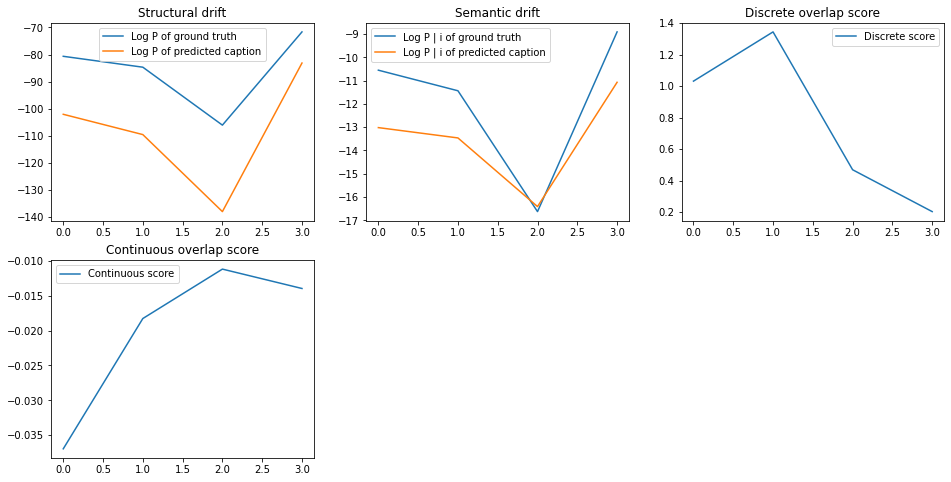

In [21]:
fig = plt.figure(figsize=(16, 8))
columns = 2
rows = 2

fig.add_subplot(2,3, 1)
plt.plot(range(len(train_metrics_summary_fixed)), train_metrics_summary_fixed["structural_drift_true"], label="Log P of ground truth")
plt.plot(range(len(train_metrics_summary_fixed)), train_metrics_summary_fixed["structural_drift_pred"], label="Log P of predicted caption")
plt.legend()
plt.title("Structural drift")

fig.add_subplot(2,3, 2)
plt.plot(range(len(train_metrics_summary_fixed)), train_metrics_summary_fixed["semantic_drifts_true"], label="Log P | i of ground truth")
plt.plot(range(len(train_metrics_summary_fixed)), train_metrics_summary_fixed["semantic_drifts_pred"], label="Log P | i of predicted caption")
plt.legend()
plt.title("Semantic drift")

fig.add_subplot(2,3, 3)
plt.plot(range(len(train_metrics_summary_fixed)), train_metrics_summary_fixed["discrete_overlaps"], label="Discrete score")
plt.legend()
plt.title("Discrete overlap score")

fig.add_subplot(2,3, 4)
plt.plot(range(len(train_metrics_summary_fixed)), train_metrics_summary_fixed["continuous_overlaps"], label="Continuous score")
plt.legend()
plt.title("Continuous overlap score")

plt.show()

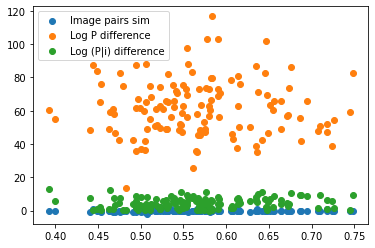

In [37]:
# plot image similarity against structral drift
# plt.plot(range(len(train_metrics["image_similarities"])), train_metrics["image_similarities"], label="Image pairs sim")
# plt.plot(range(len(train_metrics["image_similarities"])), train_metrics["discrete_overlaps"]/10, label="Discrete overlap")
plt.scatter(train_metrics["image_similarities"], train_metrics["discrete_overlaps"], label="Image pairs sim")
plt.scatter(train_metrics["image_similarities"], abs(train_metrics["structural_drift_pred"]-train_metrics["structural_drift_true"]), label="Log P difference")
plt.scatter(train_metrics["image_similarities"], abs(train_metrics["semantic_drifts_pred"]-train_metrics["semantic_drifts_true"]), label="Log (P|i) difference")

plt.legend()
plt.show()

In [36]:
np.corrcoef(train_metrics["image_similarities"], abs(train_metrics["semantic_drifts_pred"]-train_metrics["semantic_drifts_true"]))

array([[1.        , 0.01612743],
       [0.01612743, 1.        ]])

In [27]:
np.corrcoef(train_metrics["image_similarities"], abs(train_metrics["structural_drift_pred"]-train_metrics["structural_drift_true"]))

array([[1.        , 0.10836712],
       [0.10836712, 1.        ]])